# Imports

In [22]:
import requests
import json
from bs4 import BeautifulSoup
import networkx as nx
import re
from matplotlib import pyplot as plt
import matplotlib
import time
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Load statics

In [3]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

In [4]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2] 
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

In [5]:
for course_num in valid_courses:

    # Initialize BeautifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    # Define the search pattern to match both "Academic prerequisites" and "Mandatory prerequisites"
    search_pattern = r"(Academic prerequisites|Mandatory Prerequisites)"
    
    # Find the label element that matches the pattern
    label = soup.find('label', string=re.compile(search_pattern))
    if label is None:
        continue  # Skip if no label is found
    
    # Get the parent element that contains the label and prerequisites
    parent = label.find_parent().find_parent()
    
    # Get the second <td> (assuming it contains the prerequisites text)
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and line breaks
    prerequisite = prerequisite.replace('\r', ' ').replace('\n', ' ')

    # Extract 5-digit course numbers
    prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
    # Add edges to the graph for valid prerequisites
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite != course_num:  # Skip self-loops
                G.add_edge(prerequisite, course_num)


## Add text attributes

In [6]:
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

# Get evaluations and grades

In [7]:
# Evaluations
with open('eval_scores.json') as f:
    eval_scores = json.load(f)

# Grades
with open('grade_scores.json') as f:
    grade_scores = json.load(f)

In [8]:
# Apply evaluation and grade attributes
for course_num in grade_scores:
    G.nodes[course_num]['eval_scores'] = eval_scores[course_num]
    G.nodes[course_num]['grade_scores'] = grade_scores[course_num]
    
# Remove nodes from G that do not have evaluation scores
G = G.subgraph([node for node in G.nodes if 'eval_scores' in G.nodes[node]])
# Remove nodes from G with empty evaluation scores
G = G.subgraph([node for node in G.nodes if G.nodes[node]['eval_scores']])

# BIG PLOT

1. Scale = #edges
2. Color = department
3. Remove not-connected courses
4. Make undirected

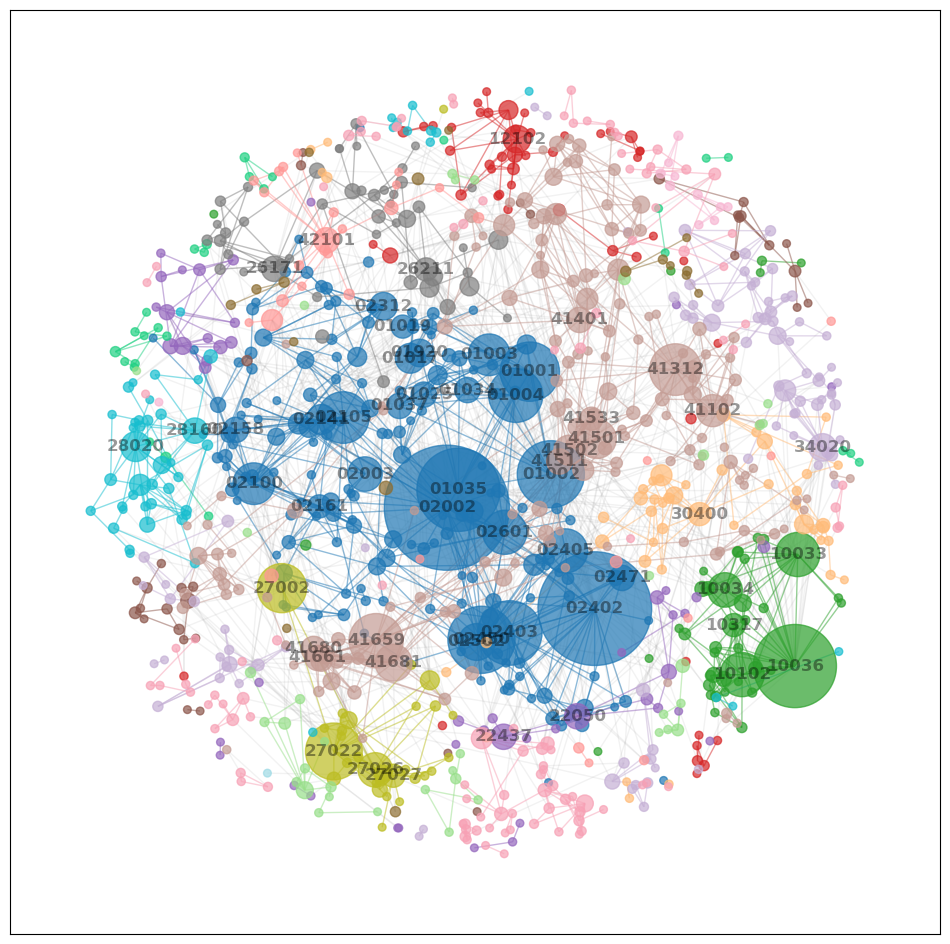

In [64]:

# Make undirected
H = G.to_undirected()
# H = G.copy()

# Remove nodes with no edges
H = H.subgraph([node for node in H.nodes if H.degree(node) > 0])

# Apply weights to edges
for edge in H.edges:
    if H.nodes[edge[0]]['department'] == H.nodes[edge[1]]['department']:
        H[edge[0]][edge[1]]['weight'] = 10
    else:
        H[edge[0]][edge[1]]['weight'] = 1


# Create layout
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(H, 
                            seed=42,
                            dissuade_hubs=True,
                            scaling_ratio=1,
                            strong_gravity=True,
                            gravity=10,
                            weight='weight')

# Draw nodes
# Nodes are colored by department
# Nodes are scaled by log(degree)
node_sizes = [30+H.degree(node)**2.3 for node in H.nodes]
# node_sizes = [H.degree(node)*50 for node in H.nodes]
node_colors = [H.nodes[node]['color'] for node in H.nodes]
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7) 

# Draw edges
# Edges are colored by department if both nodes are in same department
edge_colors = [H.nodes[edge[0]]['color'] if H.nodes[edge[0]]['department']==H.nodes[edge[1]]['department'] else 'grey' for edge in H.edges]
# edge_colors = [H.nodes[edge[0]]['color'] for edge in H.edges]
alpha = [0.5 if H.nodes[edge[0]]['department']==H.nodes[edge[1]]['department'] else 0.1 for edge in H.edges]
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, alpha=alpha)

# Draw labels if degree > 10
labels = {}
for node in H.nodes:
    if H.degree(node) > 10:
        labels[node] = H.nodes[node]['course_num']

nx.draw_networkx_labels(H, pos, labels=labels, font_size=12, font_color='black', font_weight='bold', alpha=0.4)

# Show plot
plt.show()